# AmEx Predicting Coupon Redemption - Merge Dataframes

Based on https://www.kaggle.com/vasudeva009/code-1-coupon-redemption

In [4]:
import os

import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.stats import mode

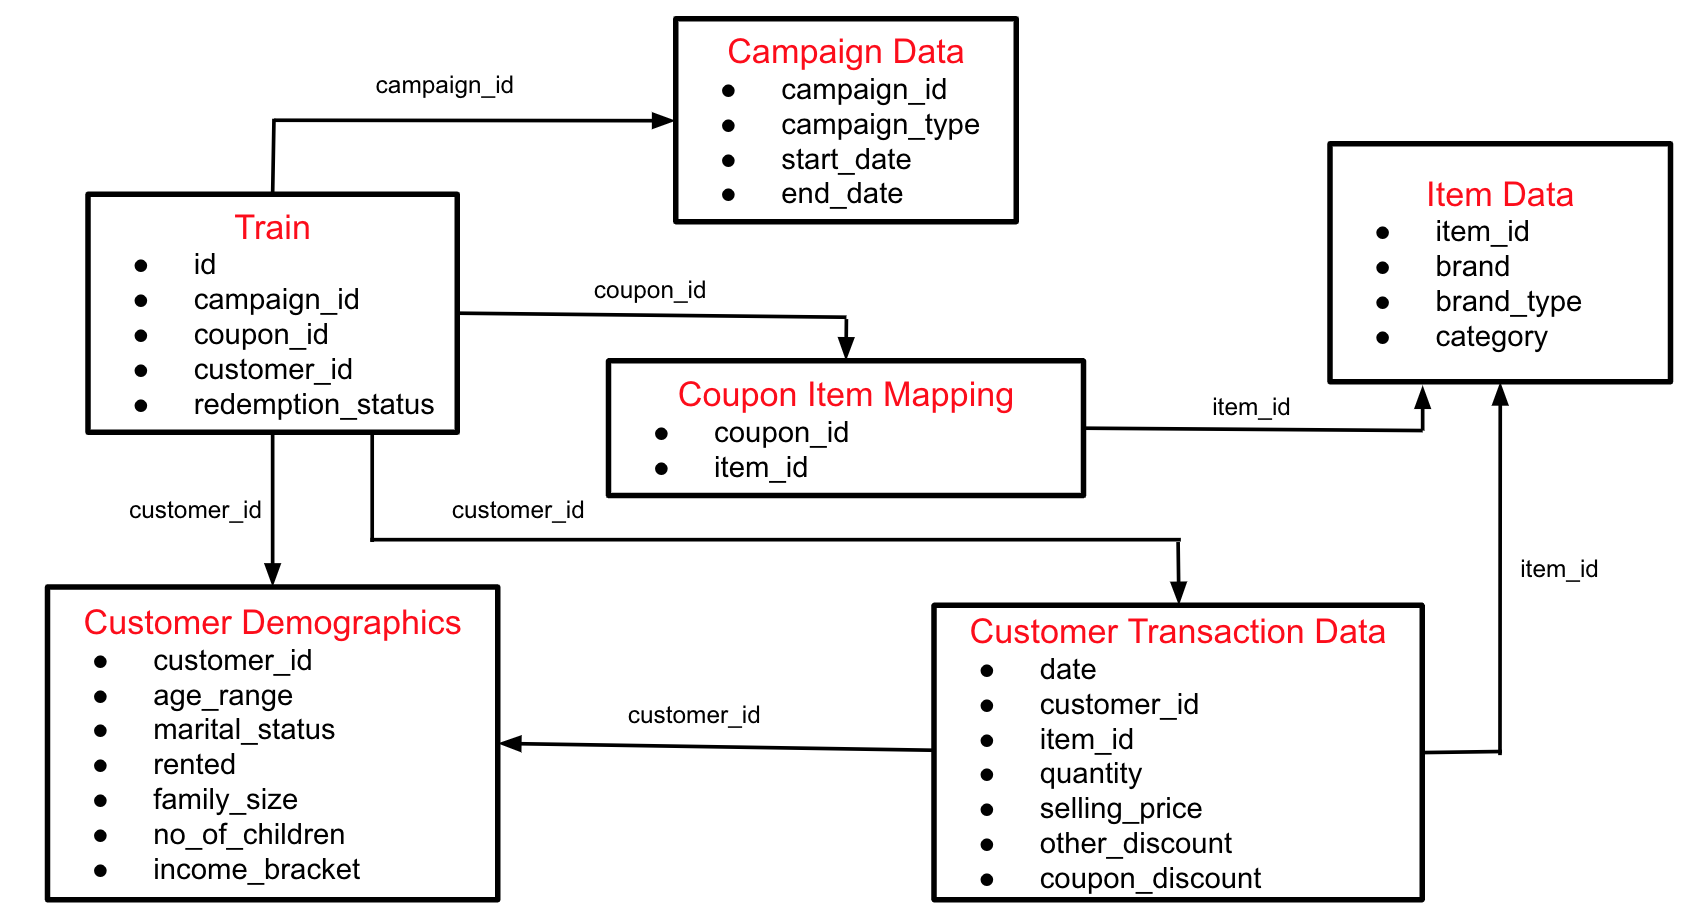

In [5]:
Image('original_data/Schema.png')

* coupon_item_mapping - maps coupons to items to which they apply (many to many relationship)
* item_data - item (product) details - maps item to its brand and category
* customer_demographics - one row for one customer


In [6]:
items = pd.read_csv('preprocessed_data/item_preprocessed.csv')
coupons = pd.read_csv('preprocessed_data/coupon_item_mapping.csv')
cust_demo = pd.read_csv('preprocessed_data/customer_demographics_preprocessed.csv')
cust_tran = pd.read_csv('preprocessed_data/customer_transaction_preprocessed.csv')
campaign = pd.read_csv('preprocessed_data/campaign_preprocessed.csv')

In [7]:
print(f'Unique coupons: {len(coupons.coupon_id.value_counts())}')
print(f'Unique customers: {len(cust_demo)}')
print(f'Unique items: {len(items)}')
print(f'Unique transactions: {len(cust_tran)}')

Unique coupons: 1116
Unique customers: 760
Unique items: 74066
Unique transactions: 1324566


In [8]:
coupon_redemption = (cust_tran.coupon_used.value_counts(normalize=True) * 100).round(decimals=2)
print(f'Percent of transactions where a coupon was used: {coupon_redemption[1]}%')

Percent of transactions where a coupon was used: 1.61%


## Merge steps
1. Merge coupon_item_mapping and item_data on item_id -> coupons_items
2. Aggregate customer_transactions_data by item_id (means and sums) -> transactions2
3. Merge 1 and 2 on item_id -> coupon_item_tran
4. Aggregate 3 on coupon_id -> transactions
5. Aggregate transactions on customer_id

6. Merge train with the following: coupon (on coupon_id), campaign (on campaign_id), cust_demo (on customer_id), transactions (on customer_id)

### Step 1 Merge coupon and item data
Merge coupon_item_mapping and item_data on item_id.

Result: **coupons_items** dataframe containing both item details and applicable coupons

In [9]:
coupons_items = pd.merge(coupons, items, on='item_id', how='left')
coupons_items.head()

,coupon_id,item_id,brand,category
0,105,37,56,6
1,107,75,56,6
2,494,76,209,6
3,522,77,278,6
4,518,77,278,6


### Step 2 Aggregate transactions

1. transactions1: Aggregate transactions by item_id: For each product (item_id), calculate: (a) number of unique customers who bought it, (b) mean product quantity bought in one transaction, (c) mean price for which the item was bought, (d) mean coupon discount for this item, (e) number of times a coupon was used to buy this item
2. transactions2: Aggregate transactions by item_id: For each product, calculate: (a) total number of purchases, (b) total quantity bought, (c) total selling price, (d) total coupon discount
3. Merge the two tables on item_id -> **transactions1**

In [10]:
transactions1 = pd.pivot_table(cust_tran, index='item_id',
                               values=['customer_id', 'quantity', 'selling_price', 'coupon_discount', 'coupon_used'],
                               aggfunc={
                                   'customer_id': lambda x: len(set(x)),
                                   'quantity': np.mean,
                                   'selling_price': np.mean,
                                   'coupon_discount': np.mean,
                                   'coupon_used': np.sum
                               })
transactions1.reset_index(inplace=True)
transactions1.rename(columns={'customer_id': 'no_of_customers', 'selling_price': 'price_mean',
                              'coupon_discount': 'discount_mean', 'quantity': 'quantity_mean'}, inplace=True)

transactions1.head()

,item_id,discount_mean,coupon_used,no_of_customers,quantity_mean,price_mean
0,1,0.0,0,2,1.0,124.31
1,2,0.0,0,1,1.0,35.26
2,3,0.0,0,1,1.0,56.64
3,4,0.0,0,1,1.0,54.85
4,5,0.0,0,1,1.0,81.57


In [11]:
transactions2 = pd.pivot_table(cust_tran, index='item_id',
                               values=['customer_id', 'quantity', 'selling_price', 'coupon_discount'],
                               aggfunc={
                                   'customer_id': len,
                                   'quantity': np.sum,
                                   'selling_price': np.sum,
                                   'coupon_discount': np.sum
                               })
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 'tran_counts', 'quantity': 'quantity_sum', 'selling_price': 'price_sum',
                              'coupon_discount': 'discount_sum'}, inplace=True)
transactions2.head()

,item_id,discount_sum,tran_counts,quantity_sum,price_sum
0,1,0.0,2,2,248.62
1,2,0.0,1,1,35.26
2,3,0.0,1,1,56.64
3,4,0.0,1,1,54.85
4,5,0.0,1,1,81.57


In [12]:
transactions1 = pd.merge(transactions1, transactions2, on='item_id', how='left')
transactions1.head()

,item_id,discount_mean,coupon_used,no_of_customers,quantity_mean,price_mean,discount_sum,tran_counts,quantity_sum,price_sum
0,1,0.0,0,2,1.0,124.31,0.0,2,2,248.62
1,2,0.0,0,1,1.0,35.26,0.0,1,1,35.26
2,3,0.0,0,1,1.0,56.64,0.0,1,1,56.64
3,4,0.0,0,1,1.0,54.85,0.0,1,1,54.85
4,5,0.0,0,1,1.0,81.57,0.0,1,1,81.57


### Step 3 Merge transaction data with item data
Merge coupons_items (from step 1) with transactions1 (from step 2)

Result: **coupon_item_trans** which extends transaction info with item info

In [13]:
item_coupon_trans = pd.merge(coupons_items, transactions1, on='item_id', how='left')
item_coupon_trans.head()

,coupon_id,item_id,brand,category,discount_mean,coupon_used,no_of_customers,quantity_mean,price_mean,discount_sum,tran_counts,quantity_sum,price_sum
0,105,37,56,6,0.0,0.0,2.0,2.285714,57.247381,0.0,7.0,16.0,400.731667
1,107,75,56,6,0.0,0.0,4.0,1.363636,38.828485,0.0,33.0,45.0,1281.340000
2,494,76,209,6,0.0,0.0,1.0,1.000000,106.500000,0.0,1.0,1.0,106.500000
3,522,77,278,6,0.0,0.0,2.0,1.000000,87.270000,0.0,2.0,2.0,174.540000
4,518,77,278,6,0.0,0.0,2.0,1.000000,87.270000,0.0,2.0,2.0,174.540000


### Step 4 Aggregate transaction info by coupon_id

Extend transaction info (including sums and means) with statistics on coupons

Result: **coupon** dataframe which, apart from statistics on transactions per item, and item info, contains statistics on transactions per item to which a coupon could be applied: (a) how much unique items have been bought, (b) brand most often bought, (c) product category most often bought, (c) mean discount applied, (d) mean number of customers who bought such item, (e) mean quantity of such items bought, (f) mean price paid, (g) number of times a coupon was used for a transaction, (h) total discount for such transactions, (i) total number of transactions, (j) total quantity of items bought, (k) total price paid

In [14]:
coupon = pd.pivot_table(item_coupon_trans, index ='coupon_id',
                        values=['item_id', 'brand', 'category', 'discount_mean', 'coupon_used', 'no_of_customers',
                                'quantity_mean', 'price_mean', 'discount_sum', 'tran_counts', 'quantity_sum',
                                'price_sum'],
                        aggfunc={
                            'item_id': lambda x: len(set(x)),
                            'brand': lambda x: mode(x)[0][0],
                            'category': lambda x: mode(x)[0][0],
                            'discount_mean': np.mean,
                            'no_of_customers': np.mean,
                            'quantity_mean': np.mean,
                            'price_mean': np.mean,
                            'coupon_used': np.sum,
                            'discount_sum': np.sum,
                            'tran_counts': np.sum,
                            'quantity_sum': np.sum,
                            'price_sum': np.sum
                        })
coupon.reset_index(inplace=True)
coupon.rename(columns={'item_id': 'item_counts'}, inplace=True)

coupon.head()

,coupon_id,brand,category,coupon_used,discount_mean,discount_sum,item_counts,no_of_customers,price_mean,price_sum,quantity_mean,quantity_sum,tran_counts
0,1,1475,9,35.0,-1.321524,-1526.31,39,14.794872,101.183245,89796.868333,1.221644,1034.0,826.0
1,2,2084,6,0.0,0.000000,0.00,2,15.000000,122.534500,8940.520000,1.137500,103.0,81.0
2,3,278,6,15.0,-2.747358,-578.81,17,8.588235,131.655894,27756.490000,1.121525,248.0,212.0
3,4,544,6,44.0,-1.485152,-881.59,24,22.333333,211.708369,142874.023333,1.020872,702.0,676.0
4,5,5357,11,0.0,0.000000,0.00,7,6.000000,403.970000,16636.570000,1.000000,44.0,44.0


### Step 5 Aggregate transactions on customer_id

1. transactions3: Aggregate transactions (cust_tran) on customer_id: For each customer, calculate: (a) number of unique items bought, (b) mean quantity of items bought, (c) mean selling price for a transaction, (d) mean discount per transaction, (e) number of times a coupon was used, (f) get most poopular day, (g) dow, and (h) month for this customer.
2. transactions4: Aggregate transactions (cust_tran) on customer_id: For each customer, calculate: (a) total number of items bought, (b) total quantity of items bought, (c) total selling price for all transactions, (d) total discount for all transactions
3. Merge the two tables on customer_id -> **transactions**

In [15]:
transactions3 = pd.pivot_table(cust_tran, index='customer_id',
                               values=['item_id', 'quantity','selling_price', 'coupon_discount',
                                       'coupon_used', 'day', 'dow', 'month'],
                               aggfunc={
                                   'item_id': lambda x: len(set(x)),
                                   'quantity': np.mean,
                                   'selling_price': np.mean,
                                   'coupon_discount': np.mean,
                                   'coupon_used': np.sum,
                                   'day': lambda x: mode(x)[0][0],
                                   'dow': lambda x: mode(x)[0][0],
                                   'month': lambda x: mode(x)[0][0]
                               })
transactions3.reset_index(inplace=True)
transactions3.rename(columns={'item_id': 'no_of_items', 'quantity': 'mean_quantity', 'selling_price': 'mean_price',
                              'coupon_discount': 'mean_discount'}, inplace=True)
transactions3.head()

,customer_id,mean_discount,coupon_used,day,dow,no_of_items,month,mean_quantity,mean_price
0,1,-2.019876,78,3,3,463,5,1.170802,97.470480
1,2,-0.595084,4,13,5,352,6,1.131265,107.805783
2,3,-3.091546,53,16,4,406,7,11.578723,85.082452
3,4,-0.404773,1,14,5,125,5,1.272727,138.256770
4,5,-0.114684,2,11,1,490,5,117.869949,115.482842


In [16]:
transactions4 = pd.pivot_table(cust_tran, index='customer_id',
                               values=['item_id', 'quantity', 'selling_price', 'coupon_discount'],
                               aggfunc={
                                   'item_id': len,
                                   'quantity': np.sum,
                                   'selling_price': np.sum,
                                   'coupon_discount': np.sum
                               })
transactions4.reset_index(inplace=True)
transactions4.rename(columns={'item_id': 'customer_id_count','quantity': 'quantity_sum', 'selling_price':'pprice_sum',
                              'coupon_discount': 'ddiscount_sum'}, inplace=True)
transactions4.head()

,customer_id,ddiscount_sum,customer_id_count,quantity_sum,pprice_sum
0,1,-2116.83,1048,1227,102149.063000
1,2,-249.34,419,474,45170.623167
2,3,-2179.54,705,8163,59983.128347
3,4,-89.05,220,280,30416.489333
4,5,-90.83,792,93353,91462.410620


In [17]:
transactions = pd.merge(transactions3, transactions4, on='customer_id', how='left')
transactions.head()

,customer_id,mean_discount,coupon_used,day,dow,no_of_items,month,mean_quantity,mean_price,ddiscount_sum,customer_id_count,quantity_sum,pprice_sum
0,1,-2.019876,78,3,3,463,5,1.170802,97.470480,-2116.83,1048,1227,102149.063000
1,2,-0.595084,4,13,5,352,6,1.131265,107.805783,-249.34,419,474,45170.623167
2,3,-3.091546,53,16,4,406,7,11.578723,85.082452,-2179.54,705,8163,59983.128347
3,4,-0.404773,1,14,5,125,5,1.272727,138.256770,-89.05,220,280,30416.489333
4,5,-0.114684,2,11,1,490,5,117.869949,115.482842,-90.83,792,93353,91462.410620


### Step 6 Merge everything with train and test

Merge train and test with the following: coupon (on coupon_id), campaign (on campaign_id), cust_demo (on customer_id), transactions (on customer_id)

In [29]:
train = pd.read_csv('original_data/train.csv')
test = pd.read_csv('original_data/test.csv')

In [35]:
def merge_all(df):
    df = pd.merge(df, coupon, on='coupon_id', how='left')
    df = pd.merge(df, campaign, on='campaign_id', how='left')
    df = pd.merge(df, cust_demo, on='customer_id', how='left')
    df = pd.merge(df, transactions, on='customer_id', how='left')
    return df

In [36]:
train = merge_all(train)
train.shape

(78369, 39)

In [37]:
test = merge_all(test)
test.shape

(50226, 38)

## Check for NaN values

In [21]:
train.isnull().sum()

id                       0
campaign_id              0
coupon_id                0
customer_id              0
redemption_status        0
brand                    0
category                 0
coupon_used_x            0
discount_mean            0
discount_sum             0
item_counts              0
no_of_customers          0
price_mean               0
price_sum                0
quantity_mean            0
quantity_sum_x           0
tran_counts              0
campaign_type            0
start_date               0
end_date                 0
campaign_duration        0
age_range            34708
marital_status       34708
rented               34708
family_size          34708
no_of_children       34708
income_bracket       34708
mean_discount            0
coupon_used_y            0
day                      0
dow                      0
no_of_items              0
month                    0
mean_quantity            0
mean_price               0
ddiscount_sum            0
customer_id_count        0
q

In [38]:
test.isnull().sum()

id                       0
campaign_id              0
coupon_id                0
customer_id              0
brand                    0
category                 0
coupon_used_x            0
discount_mean            0
discount_sum             0
item_counts              0
no_of_customers          0
price_mean               0
price_sum                0
quantity_mean            0
quantity_sum_x           0
tran_counts              0
campaign_type            0
start_date               0
end_date                 0
campaign_duration        0
age_range            19287
marital_status       19287
rented               19287
family_size          19287
no_of_children       19287
income_bracket       19287
mean_discount            0
coupon_used_y            0
day                      0
dow                      0
no_of_items              0
month                    0
mean_quantity            0
mean_price               0
ddiscount_sum            0
customer_id_count        0
quantity_sum_y           0
p

In [39]:
# Fill the NaNs with mode
def fill_nans(df):
    for col in cust_demo.columns.tolist()[1:]:
        df[col].fillna(mode(df[col]).mode[0], inplace=True)
    return df

In [40]:
train = fill_nans(train)
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
brand                0
category             0
coupon_used_x        0
discount_mean        0
discount_sum         0
item_counts          0
no_of_customers      0
price_mean           0
price_sum            0
quantity_mean        0
quantity_sum_x       0
tran_counts          0
campaign_type        0
start_date           0
end_date             0
campaign_duration    0
age_range            0
marital_status       0
rented               0
family_size          0
no_of_children       0
income_bracket       0
mean_discount        0
coupon_used_y        0
day                  0
dow                  0
no_of_items          0
month                0
mean_quantity        0
mean_price           0
ddiscount_sum        0
customer_id_count    0
quantity_sum_y       0
pprice_sum           0
dtype: int64

In [41]:
test = fill_nans(test)
test.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
brand                0
category             0
coupon_used_x        0
discount_mean        0
discount_sum         0
item_counts          0
no_of_customers      0
price_mean           0
price_sum            0
quantity_mean        0
quantity_sum_x       0
tran_counts          0
campaign_type        0
start_date           0
end_date             0
campaign_duration    0
age_range            0
marital_status       0
rented               0
family_size          0
no_of_children       0
income_bracket       0
mean_discount        0
coupon_used_y        0
day                  0
dow                  0
no_of_items          0
month                0
mean_quantity        0
mean_price           0
ddiscount_sum        0
customer_id_count    0
quantity_sum_y       0
pprice_sum           0
dtype: int64

## Drop unwanted columns and save to csv

In [42]:
train.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)
test.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [43]:
if not os.path.exists('final_data'):
    os.mkdir('final_data')
train.to_csv('final_data/final_training_data.csv', index=False)
test.to_csv('final_data/final_test_data.csv', index=False)